## Split Audio

In [2]:
from pydub import AudioSegment
import os
import pandas as pd
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
inputDirectory = '../cracklesinput/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files'

In [4]:
def split_and_read(filename, audioFile, metaDataFile, sample_rate=22000):
    print('working on audio: ' + audioFile + ' and metafile: ' + metaDataFile)
    recording_annotations = pd.read_csv(metaDataFile,
                                        names=['Start', 'End', 'Coarse', 'Fine'], delimiter='\t')

    recording_audio = AudioSegment.from_wav(audioFile)
    data = [filename]
    print(len(recording_annotations.index))

    for i in range(len(recording_annotations.index)):
        
        row = recording_annotations.loc[i]
        start = row['Start']
        end = row['End']
        coarse = int(row['Coarse'])
        fine = int(row['Fine'])
        
        audio_chunk = recording_audio[int(start*1000) : int(end*1000)]
        
        if ((coarse == 1) & (fine == 0)):
            if_coarse = True
            if_fine = False
        elif (coarse == 0) & (fine == 1):
            if_coarse = False
            if_fine = True
        elif (coarse == 0) & (fine == 0):
            if_coarse = False
            if_fine = False
        else :  # Not enough files in both fine and coarse, so not considering further
            if_coarse = True
            if_fine = True
            
        
        samples = audio_chunk.get_array_of_samples()
        audio_chunk_data = np.array(samples).astype(np.float32)/32768 # convert 24 bit wav file to 16 bit
        audio_chunk_resampled = librosa.resample(audio_chunk_data, audio_chunk.frame_rate, sample_rate, res_type='kaiser_best')
        
        data.append([audio_chunk_resampled, len(audio_chunk), if_coarse, if_fine])
        
        print ("length of audio: " ,len(audio_chunk))
        
    return data

In [5]:
all_breath_list = []
breath_lengths = []
for filename in os.listdir(inputDirectory):
    if filename.endswith(".wav"):
        audioFile = os.path.join(inputDirectory, filename)
        metaDataFile = os.path.join(inputDirectory, filename.replace(".wav",".txt"))
        data = split_and_read(filename, audioFile, metaDataFile)
        breath_chunk_data = [(d[0], d[2], d[3]) for d in data[1:]]
        all_breath_list.extend(breath_chunk_data)
        breath_lengths.extend((d[1]) for d in data[1:])
    else:
        continue

working on audio: ../cracklesinput/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/129_1b1_Ar_sc_Meditron.wav and metafile: ../cracklesinput/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/129_1b1_Ar_sc_Meditron.txt
9
length of audio:  1285
length of audio:  2672
length of audio:  2600
length of audio:  2228
length of audio:  2443
length of audio:  2571
length of audio:  2544
length of audio:  2457
length of audio:  728
working on audio: ../cracklesinput/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/216_1b1_Al_sc_Meditron.wav and metafile: ../cracklesinput/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/216_1b1_Al_sc_Meditron.txt
12
length of audio:  1228
length of audio:  1355
length of audio:  1716
length of audio:  1686
length of audio:  1643
length of audio:  2453
length of audio:  2456
length of audio:  1410
length of audio:  1154
length of audio:  1746
length of audio:  1951


length of audio:  3148
length of audio:  2719
length of audio:  462
working on audio: ../cracklesinput/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/157_1b1_Lr_sc_Meditron.wav and metafile: ../cracklesinput/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/157_1b1_Lr_sc_Meditron.txt
9
length of audio:  3743
length of audio:  4677
length of audio:  4901
length of audio:  3626
length of audio:  3346
length of audio:  3153
length of audio:  3079
length of audio:  3453
length of audio:  4752
working on audio: ../cracklesinput/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/154_3b3_Ll_mc_AKGC417L.wav and metafile: ../cracklesinput/Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/154_3b3_Ll_mc_AKGC417L.txt
5
length of audio:  2708
length of audio:  4331
length of audio:  4348
length of audio:  4499
length of audio:  3111
working on audio: ../cracklesinput/Respiratory_Sound_Database/Respirat

In [6]:
len(all_breath_list)

253

In [7]:
none=[]
coarse=[]
fine=[]
for breath in all_breath_list:
    if (breath[1] == False) & (breath[2] == False):
        none.append(breath)
    elif (breath[1] == True) & (breath[2] == False):
        coarse.append(breath)
    elif (breath[1] == False) & (breath[2] == True):
        fine.append(breath)

longest breath:  6.411 seconds
shortest breath: 0.286 seconds
Petcentage of breaths less than  5  seconds long: 0.9762845849802372 %


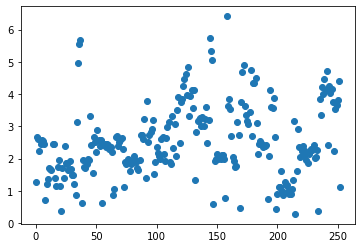

In [11]:
breath_len_arr = np.array(breath_lengths)/1000
plt.plot(breath_len_arr, 'o')
print('longest breath: ',max(breath_len_arr), "seconds")
print('shortest breath:', min(breath_len_arr), "seconds")
breath_lenght = 5
print('Petcentage of breaths less than ', breath_lenght, ' seconds long:', np.sum(breath_len_arr < breath_lenght)/len(breath_len_arr), '%')

## Split into test and train datasets

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_test_ratio = 0.2

In [14]:
none_train, none_test = train_test_split(none, test_size = train_test_ratio, random_state=10)
coarse_train, coarse_test  = train_test_split(coarse, test_size = train_test_ratio, random_state=10)
fine_train, fine_test  = train_test_split(fine, test_size = train_test_ratio, random_state=10)

In [15]:
print("Total number of files: ", len(all_breath_list))
print("Train files:")
print("None: ", len(none_train))
print("Coarse crackles: ", len(coarse_train))
print("Fine Crackles: ", len(fine_train))
print("Test files:")
print("None: ", len(none_test))
print("Coarse crackles: ", len(coarse_test))
print("Fine Crackles: ", len(fine_test))

Total number of files:  253
Train files:
None:  47
Coarse crackles:  70
Fine Crackles:  84
Test files:
None:  12
Coarse crackles:  18
Fine Crackles:  21


## Process data

In [16]:
from sklearn.preprocessing import MinMaxScaler
import scipy.signal

In [17]:
def rand_stretch(sound, rate=np.random.uniform(low=0.5,high=1.5)):
    stretched_sound = librosa.effects.time_stretch(sound, rate)
    return stretched_sound

def stretch_breaths_list(data_list, repeat, append_fraction=1):
    sound_list = [d[0] for d in data_list]
    np.random.shuffle(sound_list)
    count = int(len(sound_list) * (1-append_fraction))
    sound_list = sound_list[count:]
    if_coarse = [d[1] for d in data_list]
    if_fine = [d[2] for d in data_list]
    streched_data_list = []
    streched_data_list.extend(data_list)
    for i in range(0, repeat):
        stretched = []
        for sound in sound_list:
            stretched.append((rand_stretch(sound), if_coarse[0], if_fine[0]))
        streched_data_list.extend(stretched)
    return streched_data_list

In [18]:
def resize(data, final_len_seconds, sample_rate=22000):
    len_to_fill = int(final_len_seconds * sample_rate)
    sound = data[0]
    len_filled = len(sound)
    len_filled_seconds = len_filled / sample_rate 
    initial_sound = sound
    #print("len(initial_sound) ",len(initial_sound))
    if (len(initial_sound) < len_to_fill):
        for n in range(0, int(final_len_seconds//len_filled_seconds)-1):
            initial_sound=np.concatenate((initial_sound,sound), axis=0)
        #print ("len_to_fill " , len_to_fill)
        #print("len(initial_sound) after concatenate ",len(initial_sound))
        len_to_pad = len_to_fill-len(initial_sound)
        final_data = np.pad(initial_sound, [(0, len_to_pad)], mode='constant', constant_values=0)#Pad with zeros
    else:
        #print("greater")
        rate=len(initial_sound)/len_to_fill
        final_data = librosa.effects.time_stretch(initial_sound, rate)
    #print("final length ", len(final_data))
    return (final_data, data[1], data[2])

In [19]:
#His
def get_mel_filterbanks(sound_data, sample_rate, n_filters):
    n_rows = 175 # 7500 cutoff
    n_window = 512 #~25 ms window
    
    (f, t, Sxx) = scipy.signal.spectrogram(sound_data,fs = sample_rate, nfft= n_window, nperseg=n_window)
    
    mel_log = python_speech_features.fbank(signal=Sxx[:175,:], nfilt = n_filters, samplerate=sample_rate, lowfreq = python_speech_features.hz2mel(min(f)), highfreq = python_speech_features.hz2mel(max(f)))[0]

    scaler = MinMaxScaler()
    scaler.fit(mel_log)
    scaler.data_max_
    norm_mel_log=scaler.transform(mel_log)
    
    return np.reshape(norm_mel_log, (n_filters,Sxx.shape[1],1)).astype(np.float32)

In [20]:
def one_hot_encode(data):
    if (data[1] == False) & (data[2] == False):
        one_hot_label = np.array([1,0,0])
    elif (data[1] == True) & (data[2] == False):
        one_hot_label = np.array([0,1,0])
    elif (data[1] == False) & (data[2] == True):
        one_hot_label = np.array([0,0,1])
    return one_hot_label  

In [21]:
def resize_mel_and_onehot_list(data_list, final_len_seconds, sample_rate=22000):
    final_list=[]
    for data in data_list:
        resized = resize(data, final_len_seconds, sample_rate)
        mel = get_mel_filterbanks(resized[0], sample_rate, 50)
        print(np.shape(mel))
        one_hot_label = one_hot_encode(data)
        final_list.append((mel, one_hot_label))
    return final_list

In [22]:
none_stretched_train=stretch_breaths_list(none_train, 5, 0.94)
coarse_stretched_train=stretch_breaths_list(coarse_train, 4, 0.72)
fine_stretched_train=stretch_breaths_list(fine_train, 3, 0.75)

In [23]:
none_final_train = resize_mel_and_onehot_list(none_stretched_train,5)
coarse_final_train = resize_mel_and_onehot_list(coarse_stretched_train,5)
fine_final_train = resize_mel_and_onehot_list(fine_stretched_train,5)

(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)

(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)

In [24]:
print("Train files:")
print("None: ", len(none_final_train))
print("Coarse crackles: ", len(coarse_final_train))
print("Fine Crackles: ", len(fine_final_train))

Train files:
None:  272
Coarse crackles:  274
Fine Crackles:  273


In [25]:
train_dict = {'none':none_final_train,'coarsecrackles':coarse_final_train,'finecrackles':fine_final_train}

In [26]:
none_resize_test = resize_mel_and_onehot_list(none_test,5)
coarse_resize_test = resize_mel_and_onehot_list(coarse_test,5)
fine_resize_test = resize_mel_and_onehot_list(fine_test,5)

(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)
(50, 245, 1)


In [27]:
test_dict = {'none':none_resize_test,'coarsecrackles':coarse_resize_test,'finecrackles':fine_resize_test}

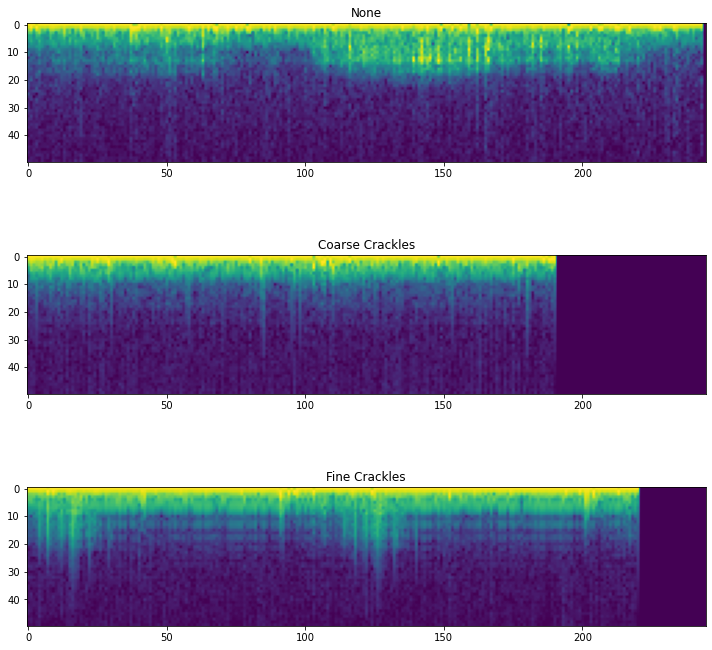

In [28]:
#Example of tiled sound samples
sample_height = train_dict['none'][0][0].shape[0]
sample_width = train_dict['none'][0][0].shape[1]
ind = 10
plt.figure(figsize = (10,10))
plt.subplot(3,1,1)
plt.imshow(train_dict['none'][ind][0].reshape(sample_height, sample_width))
plt.title('None')
plt.subplot(3,1,2)
plt.imshow(train_dict['coarsecrackles'][ind][0].reshape(sample_height, sample_width))
plt.title('Coarse Crackles')
plt.subplot(3,1,3)
plt.imshow(train_dict['finecrackles'][ind][0].reshape(sample_height, sample_width))
plt.title('Fine Crackles')
plt.tight_layout()

In [29]:
def shuffle_together(sounds, labels):
    rng_state = np.random.get_state()
    np.random.shuffle(sounds)
    np.random.set_state(rng_state)
    np.random.shuffle(labels)
    return (sounds, labels)

In [30]:
none = [i[0] for i in train_dict['none']]
fine = [i[0] for i in train_dict['finecrackles']]
coarse = [i[0] for i in train_dict['coarsecrackles']]
none_l = [i[1] for i in train_dict['none']]
fine_l = [i[1] for i in train_dict['finecrackles']]
coarse_l = [i[1] for i in train_dict['coarsecrackles']]

In [31]:
none_t = [i[0] for i in test_dict['none']]
fine_t = [i[0] for i in test_dict['finecrackles']]
coarse_t = [i[0] for i in test_dict['coarsecrackles']]
none_lt = [i[1] for i in test_dict['none']]
fine_lt = [i[1] for i in test_dict['finecrackles']]
coarse_lt = [i[1] for i in test_dict['coarsecrackles']]

In [32]:
x_train = np.vstack((none, fine, coarse))

In [33]:
y_train = np.vstack((none_l, fine_l, coarse_l))

In [34]:
x_train,y_train = shuffle_together(x_train,y_train)

In [35]:
x_val = np.vstack((none_t, fine_t, coarse_t))

In [36]:
y_val = np.vstack((none_lt, fine_lt, coarse_lt))

In [37]:
x_val,y_val = shuffle_together(x_val,y_val)

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(width_shift_range=0.2,height_shift_range=0.2)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(width_shift_range=0.2,height_shift_range=0.2)
datagen_val.fit(x_val)

In [44]:
batch_size = 32
n_epochs = 30

In [45]:
#Keras implementation
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Activation, Dropout, MaxPool2D, Flatten, LeakyReLU, BatchNormalization
import tensorflow as tf
K.clear_session()

model = Sequential()
model.add(Conv2D(128, [7,11], strides = [2,2], padding = 'SAME', input_shape = (sample_height, sample_width, 1)))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [5,5], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(Dense(256, kernel_regularizer='l2'))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(256, [1,1], padding = 'SAME'))
model.add(Dense(256))
model.add(Dropout(0.2))

model.add(Conv2D(256, [3,3], padding = 'SAME'))
model.add(LeakyReLU(alpha = 0.1))
model.add(MaxPool2D(padding = 'SAME'))

model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Dense(512))
model.add(Dropout(0.1))
model.add(Conv2D(512, [3,3], padding = 'SAME',activation = 'relu'))
model.add(Conv2D(512, [1,1], padding = 'SAME'))
model.add(Dense(512, kernel_regularizer='l2'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Conv2D(512, [3,3], padding = 'SAME', activation = 'relu'))
model.add(MaxPool2D(padding = 'SAME'))
model.add(Flatten())

model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(512, activation = 'relu'))
model.add(Dense(3, activation = 'softmax'))

In [46]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True
)
optimizer = optimizers.Adam(learning_rate=lr_schedule)

In [47]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 123, 128)      9984      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 25, 123, 128)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 62, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 62, 256)       819456    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 13, 62, 256)       0         
_________________________________________________________________
dense (Dense)                (None, 13, 62, 256)       65792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 31, 256)        0

In [49]:
stats = model.fit(x_train, 
                  y_train,
                  #steps_per_epoch = len(x_train) // batch_size,
                  validation_data = (x_val, y_val),
                  validation_steps = len(x_val) // batch_size,
                  epochs=n_epochs
                 )

Train on 819 samples, validate on 51 samples
Epoch 1/30
819/819 [==============================] - 75s 91ms/sample - loss: 8.5393 - acc: 0.4188 - val_loss: 5.2454 - val_acc: 0.6250
Epoch 2/30
819/819 [==============================] - 73s 89ms/sample - loss: 8.0584 - acc: 0.5531 - val_loss: 5.0401 - val_acc: 0.6250
Epoch 3/30
819/819 [==============================] - 76s 92ms/sample - loss: 7.6688 - acc: 0.6264 - val_loss: 4.8663 - val_acc: 0.5938
Epoch 4/30
819/819 [==============================] - 75s 92ms/sample - loss: 7.3788 - acc: 0.6459 - val_loss: 4.7351 - val_acc: 0.7500
Epoch 5/30
819/819 [==============================] - 82s 100ms/sample - loss: 7.1148 - acc: 0.6886 - val_loss: 4.6260 - val_acc: 0.7500
Epoch 6/30
819/819 [==============================] - 78s 95ms/sample - loss: 6.8952 - acc: 0.7216 - val_loss: 4.5300 - val_acc: 0.6875
Epoch 7/30
819/819 [==============================] - 73s 90ms/sample - loss: 6.7102 - acc: 0.7753 - val_loss: 4.4688 - val_acc: 0.6875
Ep

Text(0.5, 1.0, 'Loss')

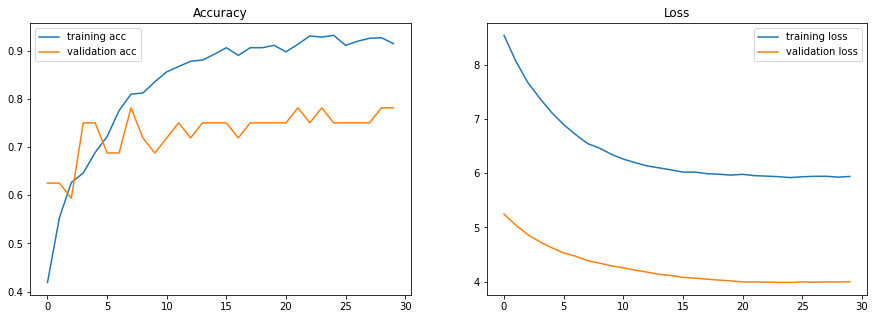

In [50]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(stats.history['acc'], label = 'training acc')
plt.plot(stats.history['val_acc'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(stats.history['loss'], label = 'training loss')
plt.plot(stats.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [52]:
predictions = model.predict(x_val)
predictions = np.argmax(predictions, axis = 1)
labels = np.argmax(y_val, axis = 1)
predictions

array([1, 0, 2, 2, 2, 1, 2, 0, 1, 2, 1, 0, 2, 1, 0, 2, 0, 2, 2, 2, 2, 0,
       0, 1, 2, 1, 2, 2, 1, 1, 2, 0, 0, 1, 1, 2, 2, 0, 2, 2, 2, 2, 1, 1,
       1, 2, 1, 2, 2, 2, 2])

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(labels, predictions, target_names = ['none','coarse crackles','fine crackles']))
cm = confusion_matrix(labels, predictions)
print(cm)

                 precision    recall  f1-score   support

           none       0.80      0.67      0.73        12
coarse crackles       0.80      0.67      0.73        18
  fine crackles       0.73      0.90      0.81        21

       accuracy                           0.76        51
      macro avg       0.78      0.75      0.75        51
   weighted avg       0.77      0.76      0.76        51

[[ 8  2  2]
 [ 1 12  5]
 [ 1  1 19]]


In [54]:
labels = ['none','coarse crackles','fine crackles']
cm_df = pd.DataFrame(cm, columns=labels, index=labels)

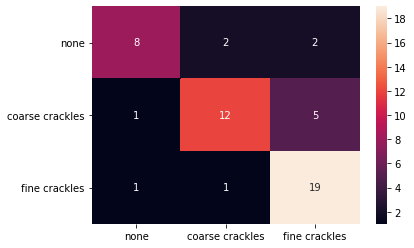

In [55]:
import seaborn as sns
ax = sns.heatmap(cm_df, annot=True, fmt='g')